In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
dt_string = datetime.now().strftime("%m-%d-%Y %H:%M:%S")

## Parameters and Equations

In [3]:
np.random.seed(4)

ft = 1
dt = 0.01

wt_gk = 30 
yugo_gk = 0
F = 5.6 
E_m = 8

Vk0 = 30
b0 = 0.6
ge = 1
gn = .08
Vn = -130

# parameters for quinine addition
gn_q = 0.005
gk_q = 1

def f(vne,t):
    V, n, E, I = vne
    a = germ
    b = b0
    Vks = Vk0*np.log(E/I)
    dVdt = -gk*n**4*(V-Vks) - gn*n**4*(V-Vn)
    dndt = a*(1-n)-b*n
    dEdt = F*gk*n**4*(V-Vks) - ge*(E-E_m) + F*gn*n**4*(V-Vn)
    dIdt = -F*gk*n**4*(V-Vks) - F*gn*n**4*(V-Vn)
    return [dVdt, dndt, dEdt, dIdt]

# with addition of quinine
def f_q(vne,t):
    V, n, E, I = vne
    a = germ
    b = b0
    Vks = Vk0*np.log(E/I)
    dVdt = -gk_q*n**4*(V-Vks) - gn_q*n**4*(V-Vn)
    dndt = a*(1-n)-b*n
    dEdt = F*gk_q*n**4*(V-Vks) - ge*(E-E_m) + F*gn_q*n**4*(V-Vn)
    dIdt = -F*gk_q*n**4*(V-Vks) - F*gn_q*n**4*(V-Vn)
    return [dVdt, dndt, dEdt, dIdt]

In [4]:

# parameters for initial intracellular potassium values for each mutant 
wt_mean = 300
yugo_mean = 280
ktrc_mean = 275
wt_std = 15
yugo_std = 35
ktrc_std = 15

# number of spores in each population
ncells = 500

# potassium threshold for germination 
k_threshold = 235 

germ_pulse = 3 # minutes of germinant pulse
wait_interpulse = 57+60 # minutes of no germinant between pulses
init = 60 # minutes of pre-germinant initialization
wait_final = 500 # post-pulse time (wait for all cells to germinate) 
num_pulses = 8
max_germ = 3 # maximum germinant concentration

# initial membrane potentials 
V0 = -79
V0_ktrc = -81
V0_yugo = -80



## Generate representative membrane potential plots

In [5]:
# Initial potassium content for four representative spores, germinating at different germinant pulses
wt_mp_rep_traces = []
i0_reps = [wt_mean-30, wt_mean, wt_mean+15, wt_mean+30]
gk = wt_gk

for i0 in i0_reps:
    germ = 0 # presence of germinant. germ = 0 when there is no germinant, and max_germ during a pulse
    Tmax = init*ft

    vne0 = [V0, 0, E_m, i0]
    tvec0 = np.arange(0,Tmax,dt)
    vne0_out = odeint(f, vne0, tvec0)
    current_state = [vne0_out[-1,0], vne0_out[-1,1], vne0_out[-1,2], vne0_out[-1,3]]
    tts = tvec0
    Its = vne0_out[:,3]
    Vts = vne0_out[:,0]
    nts = vne0_out[:,1]
    Ets = vne0_out[:,2]
    time_elapsed = tvec0[-1]

    for pulse in range(num_pulses):
        if pulse == num_pulses - 1:
            wait = wait_final
        else:
            wait = wait_interpulse
        germ = max_germ
        Tmax = germ_pulse*ft
        vne1 = current_state
        tvec1 = np.arange(0,Tmax,dt)
        vne1_out = odeint(f, vne1, tvec1)
        current_state = [vne1_out[-1,0], vne1_out[-1,1], vne1_out[-1,2], vne1_out[-1,3]]
        tts = np.concatenate((tts,tvec1[:]+time_elapsed),axis=0)
        time_elapsed=tts[-1]
        Its = np.concatenate((Its, vne1_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne1_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne1_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne1_out[:,2]),axis=0)

        germ = 0
        Tmax = wait*ft
        tvec2 = np.arange(0,Tmax,dt)
        vne2 = current_state
        vne2_out = odeint(f, vne2, tvec2)
        current_state = [vne2_out[-1,0], vne2_out[-1,1], vne2_out[-1,2], vne2_out[-1,3]]
        tts = np.concatenate((tts,tvec2+time_elapsed),axis=0)
        time_elapsed=tts[-1]
        Its = np.concatenate((Its, vne2_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne2_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne2_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne2_out[:,2]),axis=0)

# Generate time traces of each spore's intracellular potassium, until germination
    if min(Its)<k_threshold:
        for j in range(len(Its)):
            if Its[j] < k_threshold:
                wt_mp_rep_traces.append(Vts[:j])
                break


### Plot representative membrane potential time traces


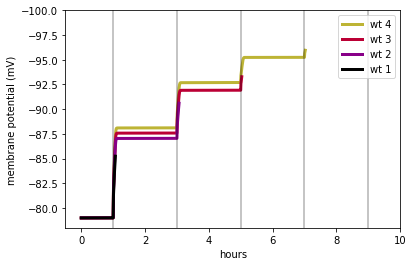

In [6]:
plt.plot(tts[:len(wt_mp_rep_traces[3])]/60,wt_mp_rep_traces[3], c= '#bdb435',label='wt 4',linewidth=3)
plt.plot(tts[:len(wt_mp_rep_traces[2])]/60,wt_mp_rep_traces[2], c= '#bb0035',label='wt 3',linewidth=3)
plt.plot(tts[:len(wt_mp_rep_traces[1])]/60,wt_mp_rep_traces[1], c= '#880088',label='wt 2',linewidth=3)
plt.plot(tts[:len(wt_mp_rep_traces[0])]/60,wt_mp_rep_traces[0], c= '#000000',label='wt 1',linewidth=3)

plt.xlabel('hours')
plt.ylabel('membrane potential (mV)')
plt.ylim(-78, -100)
plt.xlim(-.5, 10)
plt.legend()
for i in range(0, num_pulses):
    plt.axvline((i*(wait_interpulse+germ_pulse) + init)/60, c='black', alpha=0.3)
#plt.savefig(dt_string+'wt_mp_trace_representative.pdf')
plt.show()

## Calculate membrane potential time traces for a population of cells

### Determine initial potassium levels for each spore

In [7]:
np.random.seed(4)
k_wt = np.random.normal(wt_mean, wt_std, ncells)
k_yugo = np.random.normal(yugo_mean,yugo_std,ncells)
k_ktrc = np.random.normal(ktrc_mean, ktrc_std, ncells)

### Plot distributions of initial potassium levels

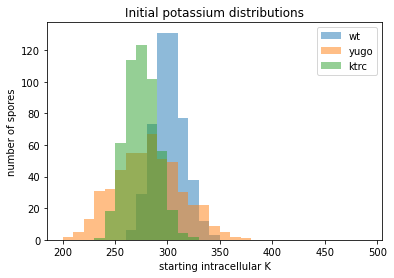

In [8]:
plt.hist(k_wt, label="wt",bins=np.arange(200,500,10),alpha = 0.5)
plt.hist(k_yugo, label="yugo",bins=np.arange(200,500,10),alpha = 0.5)
plt.hist(k_ktrc, label='ktrc',bins=np.arange(200,500,10), alpha = 0.5)
plt.xlabel('starting intracellular K')
plt.ylabel('number of spores')
plt.legend()
#plt.savefig(dt_string+' starting_k_hist.png')
plt.title('Initial potassium distributions')
plt.show()

In [9]:
# if no germination, set germination time to this maximum number
max_time = (num_pulses+1)*120 + 1000 

#### Keep track of membrane potential of each spore during simulation

In [10]:
# end value of membrane potential
wt_mp = []
ktrc_mp = []
yugo_mp = []

# time traces
wt_mp_traces = []
ktrc_mp_traces = []
yugo_mp_traces = []

### Wild-type spores

In [11]:
gk = wt_gk

wt_germ = [max_time]*ncells
yugo_germ = [max_time]*ncells
ktrc_germ = [max_time]*ncells
ktrc_rescue_germ = [max_time]*ncells
count=0
for index in range(ncells):
    i0 = k_wt[index]
    germ = 0
    Tmax = init*ft
    vne0 = [V0, 0, E_m, i0]
    tvec0 = np.arange(0,Tmax,dt)
    vne0_out = odeint(f, vne0, tvec0)
    current_state = [vne0_out[-1,0], vne0_out[-1,1], vne0_out[-1,2], vne0_out[-1,3]]
    tts = tvec0
    Its = vne0_out[:,3]
    Vts = vne0_out[:,0]
    nts = vne0_out[:,1]
    Ets = vne0_out[:,2]
    time_elapsed = tvec0[-1]

    for pulse in range(num_pulses):
        if pulse == num_pulses - 1:
            wait = wait_final
        else:
            wait = wait_interpulse
        germ = max_germ
        Tmax = germ_pulse*ft
        vne1 = current_state
        tvec1 = np.arange(0,Tmax,dt)
        vne1_out = odeint(f, vne1, tvec1)
        current_state = [vne1_out[-1,0], vne1_out[-1,1], vne1_out[-1,2], vne1_out[-1,3]]
        tts = np.concatenate((tts,tvec1[:]+time_elapsed),axis=0)
        time_elapsed=tts[-1] 
        Its = np.concatenate((Its, vne1_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne1_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne1_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne1_out[:,2]),axis=0)

        germ = 0
        Tmax = wait*ft
        tvec2 = np.arange(0,Tmax,dt)
        vne2 = current_state
        vne2_out = odeint(f, vne2, tvec2)
        current_state = [vne2_out[-1,0], vne2_out[-1,1], vne2_out[-1,2], vne2_out[-1,3]]
        tts = np.concatenate((tts,tvec2+time_elapsed),axis=0)
        time_elapsed=tts[-1] 
        Its = np.concatenate((Its, vne2_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne2_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne2_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne2_out[:,2]),axis=0)

    if min(Its)<k_threshold:
        for j in range(len(Its)):
            if Its[j] < k_threshold:
                wt_germ[index] = tts[j]
                wt_mp.append(Vts[j])
                wt_mp_traces.append(Vts[:j+1])
                break


### dYugO spores

In [12]:
gk = yugo_gk # no potassium channel 
for index in range(ncells):
    i0 = k_yugo[index]
    germ = 0
    Tmax = init*ft
    vne0 = [V0_yugo, 0, E_m, i0]
    tvec0 = np.arange(0,Tmax,dt)
    vne0_out = odeint(f, vne0, tvec0)
    current_state = [vne0_out[-1,0], vne0_out[-1,1], vne0_out[-1,2], vne0_out[-1,3]]
    tts = tvec0
    Its = vne0_out[:,3]
    Vts = vne0_out[:,0]
    nts = vne0_out[:,1]
    Ets = vne0_out[:,2]
    time_elapsed = tvec0[-1]

    for pulse in range(num_pulses):
        if pulse == num_pulses - 1:
            wait = wait_final
        else:
            wait = wait_interpulse
        germ = max_germ
        Tmax = germ_pulse*ft
        vne1 = current_state
        tvec1 = np.arange(0,Tmax,dt)
        vne1_out = odeint(f, vne1, tvec1)
        current_state = [vne1_out[-1,0], vne1_out[-1,1], vne1_out[-1,2], vne1_out[-1,3]]
        tts = np.concatenate((tts,tvec1[:]+time_elapsed),axis=0)
        time_elapsed=tts[-1]
        Its = np.concatenate((Its, vne1_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne1_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne1_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne1_out[:,2]),axis=0)

        germ = 0
        Tmax = wait*ft
        tvec2 = np.arange(0,Tmax,dt)
        vne2 = current_state
        vne2_out = odeint(f, vne2, tvec2)
        current_state = [vne2_out[-1,0], vne2_out[-1,1], vne2_out[-1,2], vne2_out[-1,3]]
        tts = np.concatenate((tts,tvec2+time_elapsed),axis=0)
        time_elapsed=tts[-1] 
        Its = np.concatenate((Its, vne2_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne2_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne2_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne2_out[:,2]),axis=0)
    
    if min(Its)<k_threshold:
        for j in range(len(Its)):
            if Its[j] < k_threshold:
                yugo_germ[index] = tts[j]
                yugo_mp.append(Vts[j])
                yugo_mp_traces.append(Vts[:j+1]) 
                break                           
    else: 
        yugo_germ[index] = max_time
        yugo_mp.append(Vts[-1])
        yugo_mp_traces.append(Vts)
    

### dKtrC spores

In [13]:
gk = wt_gk
for index in range(ncells):
    i0 = k_ktrc[index]
    germ = 0
    Tmax = init*ft
    vne0 = [V0_ktrc, 0, E_m, i0]
    tvec0 = np.arange(0,Tmax,dt)
    vne0_out = odeint(f, vne0, tvec0)
    current_state = [vne0_out[-1,0], vne0_out[-1,1], vne0_out[-1,2], vne0_out[-1,3]]
    tts = tvec0
    Its = vne0_out[:,3]
    Vts = vne0_out[:,0]
    nts = vne0_out[:,1]
    Ets = vne0_out[:,2]
    time_elapsed = tvec0[-1]

    for pulse in range(num_pulses):
        if pulse == num_pulses - 1:
            wait = wait_final
        else:
            wait = wait_interpulse
        germ = max_germ
        Tmax = germ_pulse*ft
        vne1 = current_state
        tvec1 = np.arange(0,Tmax,dt)
        vne1_out = odeint(f, vne1, tvec1)
        current_state = [vne1_out[-1,0], vne1_out[-1,1], vne1_out[-1,2], vne1_out[-1,3]]
        tts = np.concatenate((tts,tvec1[:]+time_elapsed),axis=0)
        time_elapsed=tts[-1]
        Its = np.concatenate((Its, vne1_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne1_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne1_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne1_out[:,2]),axis=0)

        germ = 0
        Tmax = wait*ft
        tvec2 = np.arange(0,Tmax,dt)
        vne2 = current_state
        vne2_out = odeint(f, vne2, tvec2)
        current_state = [vne2_out[-1,0], vne2_out[-1,1], vne2_out[-1,2], vne2_out[-1,3]]
        tts = np.concatenate((tts,tvec2+time_elapsed),axis=0)
        time_elapsed=tts[-1]
        Its = np.concatenate((Its, vne2_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne2_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne2_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne2_out[:,2]),axis=0)
    
    if min(Its)<k_threshold:
        for j in range(len(Its)):
            if Its[j] < k_threshold:
                ktrc_germ[index] = tts[j]
                ktrc_mp.append(Vts[j])
                ktrc_mp_traces.append(Vts[:j+1])
                break


### Get cumulative number of spores that have germinated, over time

In [14]:
wt_c = []
yugo_c = []
ktrc_c = []

final_wt = np.asarray(wt_germ)
final_ktrc = np.asarray(ktrc_germ)
final_yugo = np.asarray(yugo_germ)

time_range = np.asarray(range(0, (wait_interpulse+germ_pulse)*num_pulses+140))

for minute in time_range:
    wt_c.append((final_wt<minute).sum())
    yugo_c.append((final_yugo<minute).sum())
    ktrc_c.append((final_ktrc<minute).sum())

#### Plot fraction of dormant spores over time

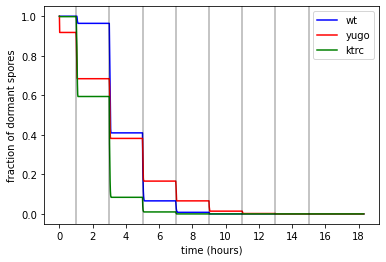

In [15]:
plt.plot(time_range/60, 1-np.asarray(wt_c)/len(final_wt), label='wt', c = 'blue')
plt.plot(time_range/60, 1-np.asarray(yugo_c)/len(final_yugo), label='yugo', c = 'red')
plt.plot(time_range/60, 1-np.asarray(ktrc_c)/len(final_ktrc), label='ktrc', c = 'green')
for i in range(0, num_pulses):
    plt.axvline((i*(wait_interpulse+germ_pulse) + init)/60, c='black', alpha=0.3)
plt.xlabel('time (hours)')
plt.ylabel('fraction of dormant spores')
plt.legend()
plt.xticks(np.arange(0,20, 2))
#plt.savefig(dt_string+'wt_and_ktrc.eps')
plt.show()

### Model addition of quinine to wild-type spores

In [16]:
quinine_mp_traces = []
wt_q_germ = [max_time]*ncells
for index in range(ncells):
    i0 = k_wt[index]
    germ = 0
    Tmax = init*ft
    vne0 = [V0, 0, E_m, i0]
    tvec0 = np.arange(0,Tmax,dt)
    vne0_out = odeint(f_q, vne0, tvec0)
    current_state = [vne0_out[-1,0], vne0_out[-1,1], vne0_out[-1,2], vne0_out[-1,3]]
    tts = tvec0
    Its = vne0_out[:,3]
    Vts = vne0_out[:,0]
    nts = vne0_out[:,1]
    Ets = vne0_out[:,2]
    time_elapsed = tvec0[-1]

    for pulse in range(num_pulses):
        if pulse == num_pulses - 1:
            wait = wait_final
        else:
            wait = wait_interpulse
        germ = max_germ
        Tmax = germ_pulse*ft
        vne1 = current_state
        tvec1 = np.arange(0,Tmax,dt)
        vne1_out = odeint(f_q, vne1, tvec1)
        current_state = [vne1_out[-1,0], vne1_out[-1,1], vne1_out[-1,2], vne1_out[-1,3]]
        tts = np.concatenate((tts,tvec1[:]+time_elapsed),axis=0)
        time_elapsed=tts[-1] 
        Its = np.concatenate((Its, vne1_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne1_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne1_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne1_out[:,2]),axis=0)

        germ = 0
        Tmax = wait*ft
        tvec2 = np.arange(0,Tmax,dt)
        vne2 = current_state
        vne2_out = odeint(f_q, vne2, tvec2)
        current_state = [vne2_out[-1,0], vne2_out[-1,1], vne2_out[-1,2], vne2_out[-1,3]]
        tts = np.concatenate((tts,tvec2+time_elapsed),axis=0)
        time_elapsed=tts[-1]
        Its = np.concatenate((Its, vne2_out[:,3]),axis=0)
        Vts = np.concatenate((Vts, vne2_out[:,0]),axis=0)
        nts = np.concatenate((nts, vne2_out[:,1]),axis=0)
        Ets = np.concatenate((Ets, vne2_out[:,2]),axis=0)

    if min(Its)<k_threshold:
        for j in range(len(Its)):
            if Its[j] < k_threshold:
                wt_q_germ[index] = tts[j]
                quinine_mp_traces.append(Vts[:j+1])
                break

#### Get cumulative number of spores that have germinated over time

In [17]:
wt_q_c = []
final_wt_q = np.asarray(wt_q_germ)
for minute in time_range:
    wt_q_c.append((final_wt_q<minute).sum())

#### Plot fraction of dormant spores over time

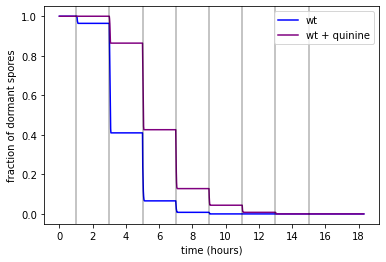

In [18]:
plt.plot(time_range/60, 1-np.asarray(wt_c)/len(final_wt), label='wt', c = 'blue')
plt.plot(time_range/60, 1-np.asarray(wt_q_c)/len(final_wt_q), label='wt + quinine', c = 'purple')
for i in range(0, num_pulses):
    plt.axvline((i*(wait_interpulse+germ_pulse) + init)/60, c='black', alpha=0.3)
plt.xlabel('time (hours)')
plt.ylabel('fraction of dormant spores')
plt.legend()
plt.xticks(np.arange(0,20, 2))
#plt.savefig(dt_string+'wt_and_ktrc.eps')
plt.show()

## Save results

In [19]:
# # Representative membrane potential time traces
# np.savetxt(dt_string+' wt_pulse1_rep.csv', wt_mp_rep_traces[0])
# np.savetxt(dt_string+' wt_pulse2_rep.csv', wt_mp_rep_traces[1])
# np.savetxt(dt_string+' wt_pulse3_rep.csv', wt_mp_rep_traces[2])
# np.savetxt(dt_string+' wt_pulse4_rep.csv', wt_mp_rep_traces[3])

# # Initial potassium concentrations for each population
# np.savetxt(dt_string+' ktrc_initial_k.csv', k_ktrc)
# np.savetxt(dt_string+' wt_initial_k.csv', k_wt)
# np.savetxt(dt_string+' yugo_initial_k.csv', k_yugo)


# # Germination times 
# np.savetxt(dt_string+' wt_germ_times.csv', final_wt)
# np.savetxt(dt_string+' ktrc_germ_times.csv', final_ktrc)
# np.savetxt(dt_string+' yugo_germ_times.csv', final_yugo)
# np.savetxt(dt_string+' wt_quinine_germ_times.csv', final_wt_q)

# # representative membrane potential traces
# np.savetxt(dt_string+' wt_mp_trace_representative.csv', wt_mean_Vts)
# np.savetxt(dt_string+' yugo_mp_trace_representative.csv', yugo_mean_Vts)
# np.savetxt(dt_string+' ktrc_mp_trace_representative.csv', ktrc_mean_Vts)


# # population membrane potential traces (note: time traces are different lengths)
# # WT membrane potential traces
# np.savetxt(dt_string+' wt_mp_traces.csv', wt_mp_traces)

# # dyugo membrane potential traces
# np.savetxt(dt_string+' yugo_mp_traces.csv', yugo_mp_traces)

# # dktrc membrane potential traces
# np.savetxt(dt_string+' ktrc_mp_traces.csv', ktrc_mp_traces)

## Load germination times and get cumulative number of germinated spores

In [20]:

wt_germ = np.loadtxt('04-07-2021 22:06:50 wt_germ_times.csv')
yugo_germ = np.loadtxt('04-07-2021 22:06:50 yugo_germ_times.csv')
ktrc_germ = np.loadtxt('04-07-2021 22:06:50 ktrc_germ_times.csv')
q_germ = np.loadtxt('04-07-2021 22:06:50 wt_quinine_germ_times.csv')

In [21]:
num_pulses = 8
wt_c = []
yugo_c = []
ktrc_c = []
q_c = []

final_wt = np.asarray(wt_germ)
final_yugo = np.asarray(yugo_germ)
final_ktrc = np.asarray(ktrc_germ)
final_q = np.asarray(q_germ)

final_wt = final_wt[final_wt != 0]
final_ktrc = final_ktrc[final_ktrc != 0]
final_yugo = final_yugo[final_yugo != 0]
final_q = final_q[final_q != 0]

time_range = np.asarray(range(0, 120*num_pulses+20+120))

for minute in time_range:
    wt_c.append((final_wt<minute).sum())
    yugo_c.append((final_yugo<minute).sum())
    ktrc_c.append((final_ktrc<minute).sum())
    q_c.append((final_q<minute).sum())